# Data importing and data preparation

In [2]:
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from google.colab import drive
import os
from keras.callbacks import ModelCheckpoint
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [12]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


IndexError: list index out of range



---


In [4]:
#monto drive e estraggo l'archivio di immagini
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [11]:
# estraggo l'archivio
!unzip -q /content/drive/MyDrive/ml/archive.zip -d '/content/MuffinChihuahua/'

In [16]:
# Lista comprensiva che genera una lista di percorsi per tutte le immagini con estensione .jpg
image_list = []
for dirname, _, filenames in os.walk("/content/MuffinChihuahua/."):
    for filename in filenames:
        if filename.endswith(".jpg"):
            path = os.path.join(dirname, filename)
            image_list.append(path)
print(len(image_list))

# Creazione di una lista di percorsi alle immagini che contengono la parola "chihuahua" nel percorso
chihuahua_images = []
for img in image_list:
    if "chihuahua" in img:
        chihuahua_images.append(img)
print(len(chihuahua_images))


# Creazione di una lista di percorsi alle immagini che contengono la parola "muffin" nel percorso
muffin_images = []
for img in image_list:
    if "muffin" in img:
        muffin_images.append(img)
print(len(muffin_images))


5917
3199
2718


In [17]:
# Creazione di una lista di etichette per le immagini, estrapolando il nome della directory padre da ciascun percorso dell'immagine
labels = []
for img in image_list:
    parts = img.split("/")
    label = parts[5]
    labels.append(label)

# Creazione di una lista di percorsi delle immagini
paths = image_list

In [18]:
# Utilizza il costruttore pd.DataFrame per creare un DataFrame pandas
# Si passa un dizionario in cui le chiavi sono i nomi delle colonne e i valori sono le liste di dati per ciascuna colonna
# "file" è il nome della colonna che conterrà i percorsi delle immagini
# "label" è il nome della colonna che conterrà le etichette di classe delle immagini
# paths è una lista contenente i percorsi completi delle immagini
# labels è una lista contenente le etichette di classe delle immagini
dataframe = pd.DataFrame({"file": paths, "label": labels})
dataframe

,file,label
0,/content/MuffinChihuahua/./test/muffin/img_3_3...,muffin
1,/content/MuffinChihuahua/./test/muffin/img_4_8...,muffin
2,/content/MuffinChihuahua/./test/muffin/img_4_2...,muffin
3,/content/MuffinChihuahua/./test/muffin/img_2_6...,muffin
4,/content/MuffinChihuahua/./test/muffin/img_1_5...,muffin
...,...,...
5912,/content/MuffinChihuahua/./train/chihuahua/img...,chihuahua
5913,/content/MuffinChihuahua/./train/chihuahua/img...,chihuahua
5914,/content/MuffinChihuahua/./train/chihuahua/img...,chihuahua
5915,/content/MuffinChihuahua/./train/chihuahua/img...,chihuahua


#Train, validation e test set

In [19]:
from sklearn.model_selection import train_test_split

# Dividi il DataFrame dataframe in due parti: train_val e test.
# La dimensione del test set è il 20% del DataFrame dataframe.
# random_state è impostato a 100 per garantire riproducibilità.
train_val, test = train_test_split(dataframe, test_size=0.2, random_state=100)

# Dividi il train_val set in due parti: train e val.
# La dimensione del validation set (val) è l'8.33% del DataFrame dataframe (1/0.8 = 0.125).
# random_state è impostato a 100 per garantire riproducibilità.
train, val = train_test_split(train_val, test_size=0.125, random_state=100)


# Training Set:
# - Utilizzato per addestrare il modello.
# - Contiene esempi di input (caratteristiche) e output (etichette/target).
# - Durante l'addestramento, il modello regola i suoi parametri (pesi e bias nei modelli neurali) per apprendere la relazione tra input e output.

# Validation Set:
# - Utilizzato per valutare le prestazioni del modello durante l'addestramento.
# - Aiuta a regolare i parametri del modello e selezionare le migliori configurazioni di iperparametri.
# - Dopo ogni iterazione di addestramento, il modello viene valutato su questo set per controllare l'overfitting e la generalizzazione.

# Test Set:
# - Utilizzato per valutare le prestazioni finali del modello.
# - Contiene dati mai visti durante l'addestramento o la validazione.
# - Le prestazioni del modello su questo set danno una stima dell'accuratezza e della capacità predittiva del modello in un contesto del mondo reale.
print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))


Training set: 4141
Validation set: 592
Test set: 1184




---



In [20]:
# Crea un oggetto ImageDataGenerator per la normalizzazione delle immagini.
# La normalizzazione consiste nel ridimensionare i valori dei pixel nell'intervallo [0,1].
img_generator = ImageDataGenerator(rescale=1. / 255)
# Imposta la dimensione del batch per l'addestramento e la validazione.
batch_size = 16

# Crea un generatore di dati per il training set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'train' e le normalizza, ridimensiona e genera i batch.
train_gen = img_generator.flow_from_dataframe(
    dataframe=train,  # DataFrame contenente i dati di addestramento
    x_col="file",  # Nome della colonna che contiene i percorsi delle immagini
    y_col="label",  # Nome della colonna che contiene le etichette di classe
    directory="/content",  # Directory base in cui cercare le immagini
    target_size=(224, 224),  # Dimensioni a cui ridimensionare le immagini (altezza, larghezza)
    batch_size=batch_size,  # Dimensione del batch
    class_mode="binary",  # Modalità di classe (in questo caso binaria)
    color_mode="rgb",  # Modalità colore delle immagini (RGB)
    seed=100,  # Seme per la casualità (per rendere l'output riproducibile)
    shuffle=True  # Mescola i dati durante l'addestramento
)

# Crea un generatore di dati per il validation set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'val' e le normalizza, ridimensiona e genera i batch.
val_gen = img_generator.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    seed=100,
    shuffle=True
)

# Crea un generatore di dati per il test set utilizzando flow_from_dataframe di norm.
# Il generatore legge le immagini dal DataFrame 'test' e le normalizza, ridimensiona e genera i batch.
test_gen = img_generator.flow_from_dataframe(
    dataframe=test,
    directory="/content",
    seed=100,
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    class_mode="binary",
    color_mode="rgb",
    shuffle=False  # Non mescola i dati durante il test
)


Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.


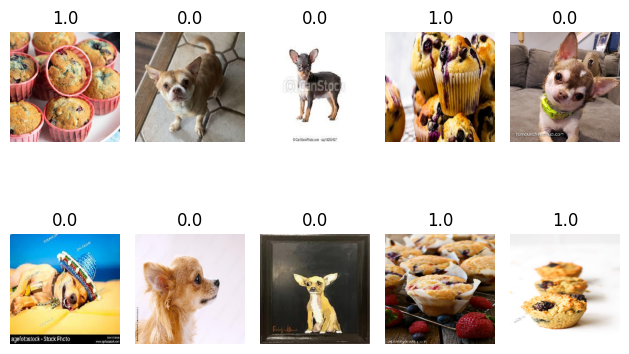

In [21]:
# Genera un batch di immagini e le relative etichette dal generatore di dati di addestramento
images, labels = train_gen.next()

# Crea una visualizzazione di 10 immagini e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')



# Mostra la visualizzazione
plt.tight_layout()
plt.show()

#Train, validation e test set (Augmentation)

In [24]:
# Crea un oggetto ImageDataGenerator per l'aumento dei dati (data augmentation).
# L'aumento dei dati è una tecnica utilizzata per generare nuove immagini di addestramento
# attraverso la trasformazione casuale delle immagini esistenti.
# In questo caso, vengono applicate diverse trasformazioni alle immagini, inclusa la rotazione,
# lo spostamento in larghezza e altezza, la distorsione, lo zoom, lo spostamento del canale e il flip orizzontale.
augmentation = ImageDataGenerator(
    rescale=1. / 255,  # Normalizza i pixel delle immagini
    rotation_range=10,  # Range di rotazione in gradi
    width_shift_range=0.2,  # Range di spostamento in larghezza
    height_shift_range=0.3,  # Range di spostamento in altezza
    shear_range=0.3,  # Range di distorsione
    zoom_range=0.3,  # Range di zoom
    channel_shift_range=10.,  # Range di spostamento del canale
    horizontal_flip=True  # Esegue il flip orizzontale delle immagini
)

# Crea un generatore di dati per il training set con aumento dei dati utilizzando flow_from_dataframe di aug.
train_gen_aug = augmentation.flow_from_dataframe(
    dataframe=train,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle=True
)

# Crea un generatore di dati per il validation set con aumento dei dati utilizzando flow_from_dataframe di aug.
val_gen_aug = augmentation.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle=True
)

Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


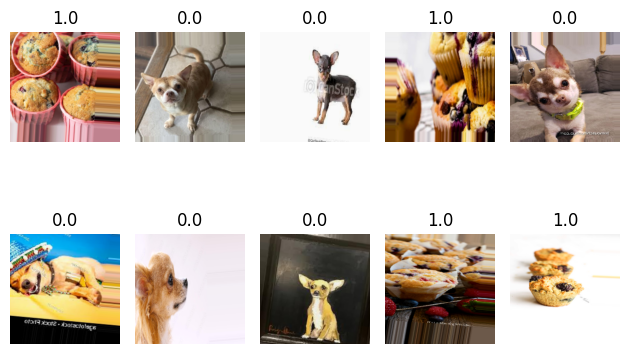

In [25]:
# Genera un batch di immagini aumentate e le rispettive etichette dal generatore di dati di addestramento con aumento dei dati
images, labels = train_gen_aug.next()

# Crea una visualizzazione di 10 immagini aumentate e le loro etichette
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_offset = random.randint(1, 10)
    if i+random_offset > len(images): random_offset=0
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

# Regola il layout della visualizzazione per una migliore disposizione
plt.tight_layout()
# Mostra la visualizzazione
plt.show()

#Metodi di training

stabilisco i parametri per la funzione fit, gli stop early e i checkpoint su drive

definisco un metodo di load per caricare i modelli da drive per evitare di rifare il training ogni volta

In [26]:
# Crea una lista di callback per l'early stopping.
# EarlyStopping è una tecnica che interrompe l'addestramento del modello se non si osserva
# un miglioramento delle prestazioni sul validation set per un numero specificato di epoche.
# - Il monitor "val_loss" controlla la perdita sul validation set.
# - "patience = 5" specifica il numero di epoche da attendere prima di fermare l'addestramento
#   se non si verifica un miglioramento della val_loss.
# - "start_from_epoch=15" specifica l'epoca da cui iniziare a monitorare la val_loss per l'early stopping.
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5,  start_from_epoch= 15)]

In [27]:
# Metodo ausiliare che serve per caricare un modello salvato nel drive
import matplotlib.image as mpimg

def load_model(model,model_weights_path):
    # Carica i pesi del modello
    model.load_weights(model_weights_path)
    # Stampare il sommario del modello
    print(model.summary())

    # Carica e mostra il plot dei valori di accuratezza
    accuracy_path = os.path.join(model_weights_path, 'accuracy_plot.png')
    accuracy_plot = mpimg.imread(accuracy_path)
    plt.imshow(accuracy_plot)
    plt.axis('off')
    plt.show()

    # Carica e mostra il plot dei valori di perdita
    loss_path = os.path.join(model_weights_path, 'loss_plot.png')
    loss_plot = mpimg.imread(loss_path)
    plt.imshow(loss_plot)
    plt.axis('off')
    plt.show()


def train_model(model, model_weights_path, stop_early = None, checkpoint = None, augmentation = 0):
    # Definisco lo stop_early e il checkpoint se non esistono già
    if not stop_early: stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5,  start_from_epoch= 15)]
    if not checkpoint: checkpoint = ModelCheckpoint(model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    # Seleziono il dataset per il training e la validation (se voglio l'augmentation o no)
    training_set = 0
    validation_set = 0
    if augmentation == 0:
      training_set = train_gen
      validation_set = val_gen
    else:
      training_set = train_gen_aug
      validation_set = val_gen

    # Eseguo il training con il model e il path presi dai parametri,
    history = model.fit(training_set, validation_data=validation_set, epochs=50, callbacks=[checkpoint, stop_early])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(model_weights_path, 'accuracy_plot.png'))

    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(model_weights_path, 'loss_plot.png'))
    plt.show()


#Definizione dei Models
utilizzo 3 modelli diversi: 2 convolutional, 2 convolutional + dropout, 3convolutional + dropout

li testo con senza e con augmentation

In [28]:
# Definizione del modello sequenziale, che è una serie di strati neurali uno dopo l'altro.
# Due strati concoluzionali
model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(units=64, activation='relu'),

    Dense(units=1, activation='sigmoid')
])
model1_weights_path = "/content/drive/MyDrive/ml/weights/model1"
model1_weights_path_aug = "/content/drive/MyDrive/ml/weights/model1augmentation"
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model1.summary()
#plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [29]:
# Due strati convoluzionali + Drop out
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])
model2_weights_path = "/content/drive/MyDrive/ml/weights/model2"
model2_weights_path_aug = "/content/drive/MyDrive/ml/weights/model2augmentation"
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)       

In [30]:
# Tre strati convoluzionali + Drop out
model3 = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),


    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])
model3_weights_path = "/content/drive/MyDrive/ml/weights/model3"
model3_weights_path_aug = "/content/drive/MyDrive/ml/weights/model3augmentation"
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 64)       

#Training e Loading dei modelli

In [10]:
# train model 1
train_model(model1,model1_weights_path)

NameError: name 'train_model' is not defined

In [11]:
# load model stored weights
load_model(model1,model1_weights_path)

NameError: name 'load_model' is not defined

In [ ]:
# train model 1 augmentation
train_model(model1,model1_weights_path_aug,augmentation=1)

In [ ]:
# load model stored weights
load_model(model1,model1_weights_path_aug)

In [ ]:
# train model 2
train_model(model2,model2_weights_path,augmentation=0)

In [ ]:
# load model stored weights
load_model(model2,model2_weights_path)

In [ ]:
# train model 2 + augmentation
train_model(model2,model2_weights_path_aug,augmentation=1)

In [ ]:
# load model stored weights
load_model(model2,model2_weights_path_aug)

In [ ]:
# train model 3
train_model(model3,model3_weights_path,augmentation=0)

In [ ]:
# load model stored weights
load_model(model3,model3_weights_path)

In [ ]:
# train model 3 + augmentation
train_model(model3,model3_weights_path_aug,augmentation=1)

In [ ]:
# load model stored weights
load_model(model3,model3_weights_path_aug)

#Hyperparameter tuning

In [39]:
#Funzione per costruire un modello di rete neurale convoluzionale con iperparametri.
#Parametri:
#    hp (HyperParameters): Un oggetto contenente gli iperparametri da regolare.
#Ritorna:
#    model (Sequential): Modello sequenziale Keras compilato con architettura specificata e iperparametri.

# model fa riderimento alla struttura del model3 visto in precedenza

def model_builder(hp):
    # Inizializzazione di un modello sequenziale
    model = keras.Sequential()

    # Aggiunta del primo layer convoluzionale con numero di filtri e dimensione del kernel regolati dagli iperparametri
    model.add(keras.layers.Conv2D(
        filters = hp.Int("convolution_1_filters", min_value=16, max_value=64, step=16), #hyperparameter
        kernel_size = (3, 3),
        input_shape = (224, 224, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(
        hp.Float("dropout_hidden_layer", min_value=0.05, max_value=0.3, step=0.05) #hyperparameter
    ))

    # Aggiunta del secondo layer convoluzionale con numero di filtri e dimensione del kernel regolati dagli iperparametri
    model.add(keras.layers.Conv2D(
        filters = hp.Int("convolution_2_filters", min_value=32, max_value=128, step=32), #hyperparameter
        kernel_size = (3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(
        hp.Float("dropout_hidden_layer", min_value=0.05, max_value=0.3, step=0.05) #hyperparameter
    ))

    # Aggiunta del terzo layer convoluzionale con numero di filtri e dimensione del kernel regolati dagli iperparametri
    model.add(keras.layers.Conv2D(
        filters = hp.Int("convolution_3_filters", min_value=64, max_value=256, step=64), #hyperparameter
        kernel_size = (3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(
        hp.Float("dropout_hidden_layer", min_value=0.05, max_value=0.3, step=0.05) #hyperparameter
    ))

    model.add(keras.layers.Flatten())

    # Aggiunta di un layer denso con numero di unità e attivazione ReLU regolati dagli iperparametri
    model.add(keras.layers.Dense(
        units = hp.Int("num_units", min_value=32, max_value=256, step=32), #hyperparameter
        activation = "relu"))
    model.add(Dropout(
        hp.Float("dropout_flatten_layer", min_value=0.2, max_value=0.5, step=0.1) #hyperparameter
    ))

    model.add(keras.layers.Dense(units=1, activation = "sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model


In [40]:
# Definizione del tuner per l'ottimizzazione bayesiana.
# Il tuner verrà utilizzato per la ricerca degli iperparametri ottimali del modello.
# - model_builder: La funzione che costruisce il modello da ottimizzare.
# - objective: L'obiettivo della ricerca degli iperparametri, che in questo caso è massimizzare la val_accuracy.
# - max_trials: Il numero massimo di tentativi da eseguire durante la ricerca degli iperparametri.
# - directory: La directory di salvataggio per i risultati dell'ottimizzazione.
# - project_name: Il nome del progetto, utilizzato per identificare i risultati dell'ottimizzazione.
# - overwrite: Se impostato su False, i risultati dell'ottimizzazione esistenti non verranno sovrascritti.
hp_tuner = kt.BayesianOptimization(
    model_builder, objective = "val_accuracy", max_trials = 5,
    directory = "/content/drive/MyDrive/hp/",
    project_name = "cnn",
    overwrite = False)

hp_tuner.search_space_summary()

Reloading Tuner from /content/drive/MyDrive/hp/cnn/tuner0.json
Search space summary
Default search space size: 6
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [38]:
# I parametri vengono salvati come variabili su drive, lanciare una sola volta
hp_tuner.search(train_gen_aug, epochs = 50,
                validation_data = val_gen,
                callbacks = stop_early)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |48                |convolution_1_filters
0.05              |0.2               |dropout_hidden_layer
128               |64                |convolution_2_filters
64                |256               |convolution_3_filters
64                |192               |num_units
0.2               |0.3               |dropout_flatten_layer

Epoch 1/50
259/259 [==============================] - 705s 3s/step - loss: 0.6130 - accuracy: 0.6713 - val_loss: 0.4950 - val_accuracy: 0.7517
Epoch 2/50
149/259 [================>.............] - ETA: 4:46 - loss: 0.5012 - accuracy: 0.7739

KeyboardInterrupt: 

In [41]:
best_hp = hp_tuner.get_best_hyperparameters(num_trials=1)[0]

In [42]:
best_hp.values

{'convolution_1_filters': 48,
 'dropout_hidden_layer': 0.25,
 'convolution_2_filters': 128,
 'convolution_3_filters': 256,
 'num_units': 128,
 'dropout_flatten_layer': 0.4}

In [35]:
hypermodel = hp_tuner.hypermodel.build(best_hp)

In [ ]:
# train hypermodel
train_model(hypermodel,'/content/drive/MyDrive/hp/hypermodel',augmentation=1)

# Predictions on test set

# 5-fold Cross Validation